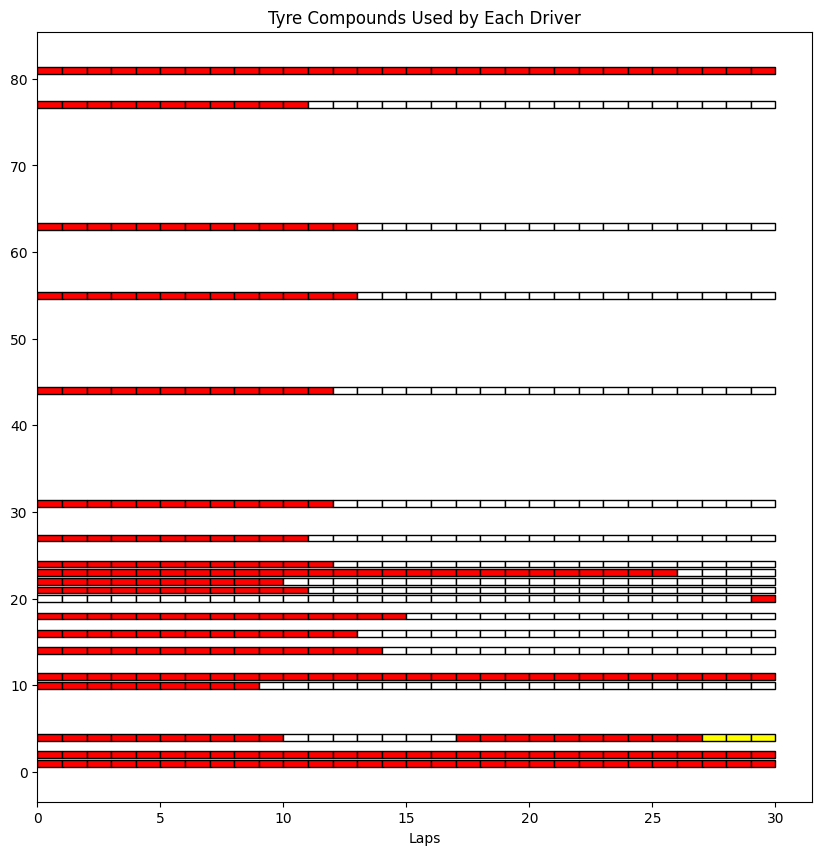

In [8]:
from flask import jsonify
import polars as pl
import matplotlib.pyplot as plt


def get_tyre_data(year, round_number, lap):

    df_lap_data = pl.scan_parquet("../static/data/all_laps.parquet")
    df_driver_data = pl.scan_parquet("../static/data/all_driver_data.parquet")

    df_lap_data = df_lap_data.select(
        [
            "round_number",
            "year",
            "Driver",
            "DriverNumber",
            "LapTime",
            "LapNumber",
            "IsPersonalBest",
            "Compound",
            "Position",
        ]
    )

    df_lap_data = df_lap_data.filter((pl.col("year") == year) & (pl.col("round_number") == round_number) & (pl.col("LapNumber") <= lap))

    df_driver_data = df_driver_data.select(["round_number", "year", "DriverNumber", "TeamColor"])

    df_lap_data = df_lap_data.join(df_driver_data, on=["round_number", "year", "DriverNumber"]).drop_nulls(subset="Position")

    grouped_lap_data = df_lap_data.group_by('DriverNumber').agg([
        pl.col('LapNumber').alias('lap'),
        pl.col('Position').alias('pos'),
        pl.col("Compound").alias('compound'),
        pl.col("TeamColor").first()
    ])

    output_dict = {}

    max_len = lap

    for row in grouped_lap_data.collect().rows():
        driver, lap_numbers, positions, compounds, team_color = row
        last_position = positions[-1]
        last_lap = lap_numbers[-1]
        last_compound = compounds[-1]

        lap_numbers.extend([last_lap] * (max_len - len(lap_numbers)))
        positions.extend([last_position] * (max_len - len(positions)))
        compounds.extend([last_compound] * (max_len - len(compounds)))

        output_dict[driver] = {
            "laps": lap_numbers,
            "positions": positions,
            "compounds": compounds,
        }


    compound_colors = {
        'Soft': 'red',
        'Medium': 'yellow',
        'Hard': 'white',
        'Intermediate': 'green',
        'Wet': 'blue'
    }

    return jsonify({"data": output_dict, "compound_colors": compound_colors})

    return output_dict


def plot_tyre_data(data):
    drivers = list(data.keys())
    max_lap = max([len(data[driver]['laps']) for driver in drivers])
    compounds = list(set([compound for driver in drivers for compound in data[driver]['compounds']]))

    compound_colors = {
        'SOFT': 'red',
        'MEDIUM': 'yellow',
        'HARD': 'white',
        'INTERMEDIATE': 'green',
        'WET': 'blue'
    }

    fig, ax = plt.subplots(figsize=(10, len(drivers) * 0.5))

    for i, driver in enumerate(drivers):
        laps = data[driver]['laps']
        compounds = data[driver]['compounds']
        team_color = data[driver]['color']
        start = 0

        for lap, compound in zip(laps, compounds):
            ax.barh(driver, 1, left=start, color=compound_colors.get(compound, 'gray'), edgecolor='black')
            start += 1

    ax.set_xlabel('Laps')
    ax.set_title('Tyre Compounds Used by Each Driver')
    plt.show()


response = get_tyre_data(2023, 1, 30)
data = response
plot_tyre_data(data)


In [9]:
response

{31: {'laps': [1.0,
   2.0,
   3.0,
   4.0,
   5.0,
   6.0,
   7.0,
   8.0,
   9.0,
   10.0,
   11.0,
   12.0,
   13.0,
   14.0,
   15.0,
   16.0,
   17.0,
   18.0,
   19.0,
   20.0,
   21.0,
   22.0,
   23.0,
   24.0,
   25.0,
   26.0,
   27.0,
   28.0,
   29.0,
   30.0],
  'positions': [11.0,
   11.0,
   11.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   9.0,
   12.0,
   12.0,
   13.0,
   19.0,
   19.0,
   18.0,
   18.0,
   18.0,
   18.0,
   18.0,
   19.0,
   19.0,
   19.0,
   19.0,
   18.0,
   17.0,
   17.0,
   16.0],
  'compounds': ['SOFT',
   'SOFT',
   'SOFT',
   'SOFT',
   'SOFT',
   'SOFT',
   'SOFT',
   'SOFT',
   'SOFT',
   'SOFT',
   'SOFT',
   'SOFT',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD',
   'HARD'],
  'color': '#2293D1'},
 16: {'laps': [1.0,
   2.0,
   3.0,
   4.0,
   5.0,
   6.0,
   7.0,
   8.0,
